In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arc

In [1]:
from modeling import Shaft

In [6]:
shaft = Shaft(initial_diameter=25)
shaft.add_step(30, 6)    # 直径增大
shaft.add_step(50, -6)    # 直径减小
shaft.add_shoulder(70, 50, 20)
shaft.add_keyway(40, 15, 3)
shaft.add_gear(100, 20, 65, 100, 100, 100)
shaft.process_features()

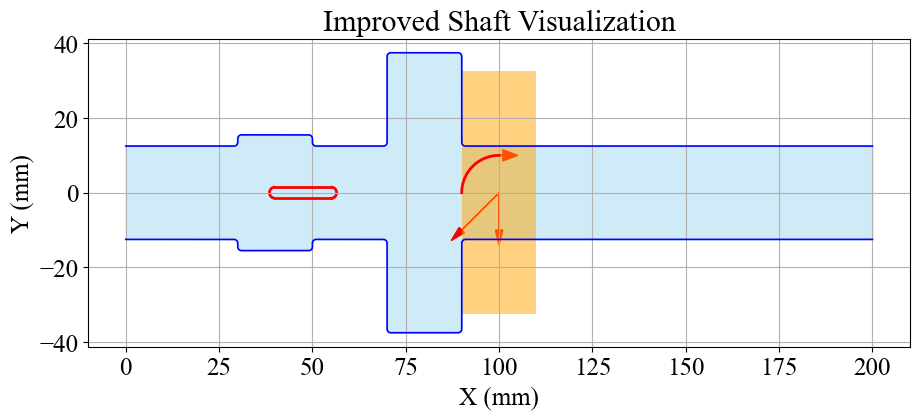

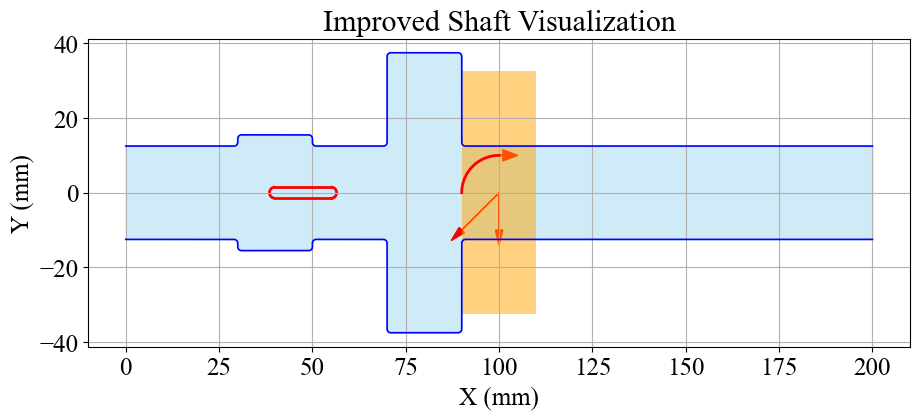

In [7]:
shaft.plot()